 # ADDA for ST

In [1]:
import warnings
from math import ceil
import glob
import os
import datetime
from itertools import chain
from copy import deepcopy

from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import mean_squared_error

import torch
from torch.nn import functional as F
from torch import nn

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_17339/2594000529.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_MARKERS = 20
N_MIX = 8
N_SPOTS = 20000
TRAIN_USING_ALL_ST_SAMPLES = False

SAMPLE_ID_N = "151673"

BATCH_SIZE = 512
NUM_WORKERS = 4
INITIAL_TRAIN_EPOCHS = 100

EARLY_STOP_CRIT = 100
MIN_EPOCHS = INITIAL_TRAIN_EPOCHS


EARLY_STOP_CRIT_ADV = 10
MIN_EPOCHS_ADV = 10

SPATIALLIBD_DIR = "./data/spatialLIBD"
SC_DLPFC_PATH = "./data/sc_dlpfc/adata_sc_dlpfc.h5ad"


In [3]:
results_folder = os.path.join("results", script_start_time)
model_folder = os.path.join("model_cell_dart", script_start_time)

model_folder = os.path.join("model_cell_dart", "TESTING")

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)


 # Define model components

In [4]:
class MLPEncoder(nn.Module):
    def __init__(self, inp_dim, emb_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(inp_dim, 1024),
            nn.BatchNorm1d(1024, eps=0.001, momentum=0.99),
            nn.ELU(),
            nn.Linear(1024, emb_dim),
            nn.BatchNorm1d(emb_dim, eps=0.001, momentum=0.99),
            nn.ELU(),
        )

    def forward(self, x):
        return self.encoder(x)


In [5]:
class Classifier(nn.Module):
    def __init__(self, emb_dim, ncls_source):
        super().__init__()

        self.head = nn.Sequential(nn.Linear(emb_dim, ncls_source), nn.LogSoftmax(dim=1))

    def forward(self, x):
        return self.head(x)


In [6]:
class Discriminator(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.BatchNorm1d(32, eps=0.001, momentum=0.99),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        return self.head(x)


In [7]:
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad


In [8]:
class ADDAST(nn.Module):
    def __init__(self, inp_dim, emb_dim, ncls_source):
        super().__init__()

        self.source_encoder = MLPEncoder(inp_dim, emb_dim)
        self.target_encoder = MLPEncoder(inp_dim, emb_dim)
        self.clf = Classifier(emb_dim, ncls_source)
        self.dis = Discriminator(emb_dim)

        self.is_encoder_source = True

    def forward(self, x):
        if self.is_encoder_source:
            x = self.source_encoder(x)
        else:
            x = self.target_encoder(x)

        x = self.clf(x)

        return x

    def pretraining(self):
        self.is_encoder_source = True
        set_requires_grad(self.source_encoder, True)
        set_requires_grad(self.clf, True)

    def advtraining(self, train_dis=True):
        set_requires_grad(self.source_encoder, False)

        if train_dis:
            self.train_discriminator()
        else:
            self.train_target_encoder()

    def target_inference(self):
        self.is_encoder_source = False

    def train_discriminator(self):
        set_requires_grad(self.target_encoder, False)
        set_requires_grad(self.dis, True)

    def train_target_encoder(self):
        set_requires_grad(self.target_encoder, True)
        set_requires_grad(self.dis, False)

    def set_encoder(self, encoder="source"):
        if encoder == "source":
            self.is_encoder_source = True
        elif encoder == "target":
            self.is_encoder_source = False
        else:
            current_encoder_str = "'source'" if self.is_encoder_source else "'target'"
            warnings.warn(
                f"encoder parameter should be 'source' or 'target', got {encoder}; encoder is currently {current_encoder_str}",
                RuntimeWarning,
            )


In [9]:
class SpotDataset(torch.utils.data.Dataset):
    """Dataset for cell spots. Returns a spot with GEx data, and optionally cell type distribution"""

    def __init__(self, X, Y=None):
        """
        Args:
            X (array_like of rank 2): An (n_spots, n_genes) array of normalized log gene expression values.
            Y (array_like of rank 2, optional): An (n_spots, n_cell_types) array of cell type distribution.
        """
        super().__init__()

        self.X = torch.as_tensor(X).float()
        assert self.X.dim() == 2, f"X should be rank 2, got {self.X.dim()}"

        if Y is None:
            self.Y = torch.empty((self.X.shape[0], 0), dtype=torch.float)
        else:
            self.Y = torch.as_tensor(Y).float()
            assert self.Y.dim() == 2, f"Y should be rank 2, got {self.Y.dim()}"
            assert len(self.X) == len(self.Y), "X and Y unequal lengths"

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


 # Prepare Data
 ## Data load
 ### Load SpatialLIBD Data

In [10]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(SPATIALLIBD_DIR, "adata")

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, "adata_spatialLIBD-*.h5ad")):
    sample_id = name.partition("-")[2].rpartition(".")[0]
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.6.0
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.2
leidenalg                   0.8.10
llvmlite                    0.38.0
matplotlib                  3.5.1
matplo

 ### Load Single Cell Data

In [11]:
adata_sc_dlpfc = sc.read_h5ad(SC_DLPFC_PATH)
sc.pp.normalize_total(adata_sc_dlpfc, inplace=True, target_sum=1e4)
adata_sc_dlpfc.var_names_make_unique()


normalizing counts per cell
    finished (0:00:00)


 ## Find Marker Genes

In [12]:
# Preprocessing
# adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
# sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# sc.pp.normalize_total(adata_sc_dlpfc)

# #PCA and clustering : Known markers with 'cell_subclass'
# sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
# sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_sc_dlpfc)
# sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
# sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])


In [13]:
# sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
# # sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)
# genelists = adata_sc_dlpfc.uns['rank_genes_groups']['names']
# df_genelists = pd.DataFrame.from_records(genelists)
# df_genelists.to_pickle('data/sc_dlpfc/df_genelists.pkl')


In [14]:
df_genelists = pd.read_pickle("data/sc_dlpfc/df_genelists.pkl")
res_genes = []
for column in df_genelists.head(NUM_MARKERS):
    res_genes.extend(df_genelists.head(NUM_MARKERS)[column].tolist())
res_genes_ = list(set(res_genes))


 ### Select same gene features

In [15]:
adata_spatialLIBD = ad.concat(
    adata_spatialLIBD_d.values(), label="sample_id", keys=adata_spatialLIBD_d.keys()
)
adata_spatialLIBD.obs_names_make_unique()
sc.pp.normalize_total(adata_spatialLIBD, inplace=True, target_sum=1e4)
st_sample_id_l = adata_spatialLIBD.obs["sample_id"].unique()


normalizing counts per cell


/home/wma/miniconda3/envs/agreda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)


In [16]:
adata_spatialLIBD.var_names_make_unique()
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print("Selected Feature Gene number", len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:, inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:, inter_genes]


Selected Feature Gene number 362


 ## Format Data

### Array of single cell & spatial data
- Single cell data with labels
- Spatial data without labels


 ### Generate Pseudospots

In [17]:
def random_mix(Xs, ys, nmix=5, n_samples=10000, seed=0):
    """Creates a weighted average random sampling of gene expression, and the
    corresponding weights.

    Args:
        X (:obj:, array_like of `float`): Matrix containing single cell samples
            and their GEx profiles
        y (:obj:, array_like of `int`): Array of cell type labels

    Shape:
        - X: `(N, C)`, where `N` is the number of single cell samples, and `C`
        is the number of genes
        - y: `(N,)`, where `N` is the number of single cell samples
        - pseudo_gex: :math: `(N_{out}, C)` where
        :math: `N_{out} = \text{n\_samples}` and `C` is the number of genes
        - ctps: `(N_{out}, C_{types})`
        where :math: `N_{out} = \text{n\_samples}` and :math: `C_{types}`
        is the number of cell types.

    Returns:
         - pseudo_gex (ndarray): Matrix containing pseudo-spot samples and their
         cell type proportion weighted averages
         - ctps (ndarray): Matrix containing pseudo-spot samples and their cell
         type proportions
    """
    # Define empty lists
    pseudogexs, ys_new = [], []
    ys_ = OneHotEncoder().fit_transform(ys.reshape(-1, 1)).toarray()

    rstate = np.random.RandomState(seed)
    fraction_all = rstate.rand(n_samples, nmix)
    randindex_all = rstate.randint(len(Xs), size=(n_samples, nmix))

    for i in range(n_samples):
        # fraction: random fraction across the "nmix" number of sampled cells
        fraction = fraction_all[i]
        fraction = fraction / np.sum(fraction)
        fraction = np.reshape(fraction, (nmix, 1))

        # Random selection of the single cell data by the index
        randindex = randindex_all[i]
        ymix = ys_[randindex]
        # Calculate the fraction of cell types in the cell mixture
        yy = np.sum(ymix * fraction, axis=0)
        # Calculate weighted gene expression of the cell mixture
        XX = np.asarray(Xs[randindex]) * fraction
        XX_ = np.sum(XX, axis=0)

        # Add cell type fraction & composite gene expression in the list
        ys_new.append(yy)
        pseudogexs.append(XX_)

    pseudogexs = np.asarray(pseudogexs)
    ys_new = np.asarray(ys_new)

    return pseudogexs, ys_new


In [18]:
def log_minmaxscale(arr):
    """returns log1pc and min/max normalized arr"""
    arrd = len(arr)
    arr = np.log1p(arr)

    arr_minus_min = arr - np.reshape(np.min(arr, axis=1), (arrd, 1))
    min2max = np.reshape((np.max(arr, axis=1) - np.min(arr, axis=1)), (arrd, 1))
    return arr_minus_min / min2max


In [19]:
df_sc = adata_sc_dlpfc.to_df()
df_sc.index = pd.MultiIndex.from_frame(adata_sc_dlpfc.obs.reset_index())

sc_sub_dict = dict(zip(range(df_genelists.shape[1]), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y, x) for x, y in sc_sub_dict.items())


In [20]:
lab_sc_sub = df_sc.index.get_level_values("cell_subclass")
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype="int")

mat_sc_train, mat_sc_eval, lab_sc_num_train, lab_sc_num_eval = train_test_split(
    df_sc.to_numpy(),
    lab_sc_num,
    test_size=0.2,
    random_state=225,
    stratify=lab_sc_num,
)

mat_sc_val, mat_sc_test, lab_sc_num_val, lab_sc_num_test = train_test_split(
    mat_sc_eval,
    lab_sc_num_eval,
    test_size=0.5,
    random_state=263,
    stratify=lab_sc_num_eval,
)

sc_mix_train, lab_mix_train = random_mix(
    mat_sc_train, lab_sc_num_train, nmix=N_MIX, n_samples=N_SPOTS
)
sc_mix_val, lab_mix_val = random_mix(
    mat_sc_val, lab_sc_num_val, nmix=N_MIX, n_samples=N_SPOTS // 8
)
sc_mix_test, lab_mix_test = random_mix(
    mat_sc_test, lab_sc_num_test, nmix=N_MIX, n_samples=N_SPOTS // 8
)


sc_mix_train_s = log_minmaxscale(sc_mix_train)
sc_mix_val_s = log_minmaxscale(sc_mix_val)
sc_mix_test_s = log_minmaxscale(sc_mix_test)


 ### Format Spatial Data

In [21]:
mat_sp_test_d = {}
mat_sp_test_s_d = {}
for sample_id in st_sample_id_l:
    mat_sp_test_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ].X.todense()

    mat_sp_test_s_d[sample_id] = log_minmaxscale(mat_sp_test_d[sample_id])

if TRAIN_USING_ALL_ST_SAMPLES:
    mat_sp_train = adata_spatialLIBD.X.todense()
    mat_sp_train_s = log_minmaxscale(mat_sp_train)
else:
    mat_sp_train_d = mat_sp_test_d
    mat_sp_train_s_d = mat_sp_test_s_d


 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [22]:
### source dataloaders
source_train_set = SpotDataset(deepcopy(sc_mix_train_s), deepcopy(lab_mix_train))
source_val_set = SpotDataset(deepcopy(sc_mix_val_s), deepcopy(lab_mix_val))
source_test_set = SpotDataset(deepcopy(sc_mix_test_s), deepcopy(lab_mix_test))

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
target_test_set_d = {}
for sample_id in st_sample_id_l:
    target_test_set_d[sample_id] = SpotDataset(deepcopy(mat_sp_test_s_d[sample_id]))

dataloader_target_test_d = {}
for sample_id in st_sample_id_l:
    dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
        target_test_set_d[sample_id],
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
    )

if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(deepcopy(mat_sp_train_s))
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
else:
    target_train_set_d = {}
    dataloader_target_train_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_test_s_d[sample_id])
        )
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
        )


 ## Define Model

In [23]:
model = ADDAST(sc_mix_train_s.shape[1], emb_dim=64, ncls_source=lab_mix_train.shape[1])
model.to(device)


ADDAST(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Classifier(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      (1): Lo

 ## Pretrain

In [24]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [25]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-07
)

criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [26]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(dataloader):

            loss = model_loss(*batch, model)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(batch))

    return np.average(loss_running, weights=mean_weights)


In [27]:
model.pretraining()


In [28]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

# Train
print("Start pretrain...")
outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)
for epoch in range(INITIAL_TRAIN_EPOCHS):

    # check to see if validation loss has plateau'd
    if early_stop_count >= EARLY_STOP_CRIT and epoch > MIN_EPOCHS:
        print(
            f"Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch"
        )
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"earlystop_{epoch}.pth"))
        break

    early_stop_count += 1

    # Train mode
    model.train()
    loss_running = []
    mean_weights = []

    inner.refresh()  # force print final state
    inner.reset()  # reuse bar
    for _, batch in enumerate(dataloader_source_train):

        pre_optimizer.zero_grad()
        loss = model_loss(*batch, model)
        loss_running.append(loss.item())
        mean_weights.append(len(batch))  # we will weight average by batch size later

        loss.backward()
        pre_optimizer.step()

        inner.update(1)

    loss_history.append(np.average(loss_running, weights=mean_weights))
    loss_history_running.append(loss_running)

    # Evaluate mode
    model.eval()
    with torch.no_grad():
        curr_loss_val = compute_acc(dataloader_source_val, model)
        loss_history_val.append(curr_loss_val)

    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
        early_stop_count = 0

    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
        checkpoint = {
            "epoch": epoch,
            "model": model,
            "optimizer": pre_optimizer,
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

    # Print the results
    outer.update(1)
    print(
        "epoch:",
        epoch,
        "train loss:",
        round(loss_history[-1], 6),
        "validation loss:",
        round(loss_history_val[-1], 6),
    )

# Save final model
checkpoint = {
    "epoch": epoch,
    "model": model,
    "optimizer": pre_optimizer,
}
torch.save(checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0 train loss: 1.19933 validation loss: 1.015744
epoch: 1 train loss: 0.842224 validation loss: 0.781362
epoch: 2 train loss: 0.676761 validation loss: 0.675613
epoch: 3 train loss: 0.608083 validation loss: 0.668591
epoch: 4 train loss: 0.573613 validation loss: 0.661825
epoch: 5 train loss: 0.554267 validation loss: 0.649621
epoch: 6 train loss: 0.535579 validation loss: 0.658148
epoch: 7 train loss: 0.522225 validation loss: 0.677202
epoch: 8 train loss: 0.507201 validation loss: 0.64501
epoch: 9 train loss: 0.493473 validation loss: 0.65161
epoch: 10 train loss: 0.481637 validation loss: 0.650266
epoch: 11 train loss: 0.469811 validation loss: 0.666225
epoch: 12 train loss: 0.459865 validation loss: 0.734886
epoch: 13 train loss: 0.445901 validation loss: 0.643477
epoch: 14 train loss: 0.427117 validation loss: 0.711232
epoch: 15 train loss: 0.417992 validation loss: 0.828821
epoch: 16 train loss: 0.406333 validation loss: 0.69094
epoch: 17 train loss: 0.392441 validation los

 ## Adversarial Adaptation

In [29]:
N_ITER = 3000
EPOCHS = 1000
ALPHA_LR = 5
ALPHA = 0.6


In [30]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [31]:
def batch_generator(data, batch_size):
    """Generate batches of data.
    Given a list of numpy data, it iterates over the list and returns batches of
    the same size
    This
    """
    all_examples_indices = len(data[0])
    while True:
        mini_batch_indices = np.random.choice(
            all_examples_indices, size=batch_size, replace=False
        )
        tbr = [k[mini_batch_indices] for k in data]
        yield tbr


In [32]:
criterion_dis = nn.CrossEntropyLoss()


def discrim_loss_accu(x, y_dis, model):
    x = x.to(torch.float32).to(device)

    emb = model.source_encoder(x)
    y_pred = model.dis(emb)

    loss = criterion_dis(y_pred, y_dis)

    accu = torch.mean(
        (torch.flatten(torch.argmax(y_pred, dim=1)) == y_dis).to(torch.float32)
    ).cpu()

    return loss, accu


def compute_acc_dis(dataloader_source, dataloader_target, model):
    len_target = len(dataloader_target)
    len_source = len(dataloader_source)

    loss_running = []
    accu_running = []
    mean_weights = []
    model.eval()
    model.source_encoder.eval()
    model.dis.eval()
    with torch.no_grad():
        for y_val, dl in zip([1, 0], [dataloader_target, dataloader_source]):
            for _, (x, _) in enumerate(dl):

                y_dis = torch.full(
                    (x.shape[0],), y_val, device=device, dtype=torch.long
                )

                loss, accu = discrim_loss_accu(x, y_dis, model)

                accu_running.append(accu)
                loss_running.append(loss.item())

                # we will weight average by batch size later
                mean_weights.append(len(x))

    return (
        np.average(loss_running, weights=mean_weights),
        np.average(accu_running, weights=mean_weights),
    )


In [33]:
def train_adversarial(
    model,
    save_folder,
    sc_mix_train_s,
    lab_mix_train,
    mat_sp_train_s,
    dataloader_source_train_eval,
    dataloader_target_train_eval,
):

    model.to(device)
    model.advtraining()
    model.set_encoder("source")

    S_batches = batch_generator(
        [sc_mix_train_s.copy(), lab_mix_train.copy()], BATCH_SIZE
    )
    T_batches = batch_generator(
        [mat_sp_train_s.copy(), np.zeros(shape=(len(mat_sp_train_s), 2))], BATCH_SIZE
    )

    enc_optimizer = torch.optim.Adam(
        chain(
            model.source_encoder.parameters(),
            model.dis.parameters(),
            model.clf.parameters(),
        ),
        lr=0.001,
        betas=(0.9, 0.999),
        eps=1e-07,
    )

    dis_optimizer = torch.optim.Adam(
        chain(model.source_encoder.parameters(), model.dis.parameters()),
        lr=ALPHA_LR * 0.001,
        betas=(0.9, 0.999),
        eps=1e-07,
    )

    # Initialize lists to store loss and accuracy values
    loss_history_running = []

    # Train
    print("Start adversarial training...")
    outer = tqdm(total=N_ITER, desc="Iterations", position=0)

    for iters in range(N_ITER):
        model.train()
        model.dis.train()
        model.clf.train()
        model.source_encoder.train()

        x_source, y_true = next(S_batches)
        x_target, _ = next(T_batches)

        ## Train encoder
        set_requires_grad(model.source_encoder, True)
        set_requires_grad(model.clf, True)
        set_requires_grad(model.dis, True)

        # save discriminator weights
        dis_weights = deepcopy(model.dis.state_dict())
        new_dis_weights = {}
        for k in dis_weights:
            if "num_batches_tracked" not in k:
                new_dis_weights[k] = dis_weights[k]

        dis_weights = new_dis_weights

        x_source, x_target, y_true, = (
            torch.Tensor(x_source),
            torch.Tensor(x_target),
            torch.Tensor(y_true),
        )
        x_source, x_target, y_true, = (
            x_source.to(device),
            x_target.to(device),
            y_true.to(device),
        )

        x = torch.cat((x_source, x_target))

        # save for discriminator later
        x_d = x.detach()

        y_dis = torch.cat(
            [
                torch.ones(x_source.shape[0], device=device, dtype=torch.long),
                torch.zeros(x_target.shape[0], device=device, dtype=torch.long),
            ]
        )

        emb = model.source_encoder(x).view(x.shape[0], -1)

        y_dis_pred = model.dis(emb)
        y_clf_pred = model.clf(emb)

        loss_dis = criterion_dis(y_dis_pred, y_dis)
        loss_clf = criterion_clf(
            y_clf_pred, torch.cat((y_true, y_clf_pred[-x_target.shape[0] :].detach()))
        )

        # loss = (x_source.shape[0] / x.shape[0]) * loss_clf + alpha * loss_dis

        loss = loss_clf + ALPHA * loss_dis

        enc_optimizer.zero_grad()
        loss.backward()
        enc_optimizer.step()

        model.dis.load_state_dict(dis_weights, strict=False)

        ## Train discriminator
        set_requires_grad(model.source_encoder, True)
        set_requires_grad(model.clf, True)
        set_requires_grad(model.dis, True)

        # save encoder and clf weights
        source_encoder_weights = deepcopy(model.source_encoder.state_dict())
        clf_weights = deepcopy(model.clf.state_dict())

        new_clf_weights = {}
        for k in clf_weights:
            if "num_batches_tracked" not in k:
                new_clf_weights[k] = clf_weights[k]

        clf_weights = new_clf_weights

        new_source_encoder_weights = {}
        for k in source_encoder_weights:
            if "num_batches_tracked" not in k:
                new_source_encoder_weights[k] = source_encoder_weights[k]

        source_encoder_weights = new_source_encoder_weights

        # flip label
        y_dis = 1 - y_dis

        emb = model.source_encoder(x_d).view(x_d.shape[0], -1)
        y_pred = model.dis(emb)
        loss = criterion_dis(y_pred, y_dis)

        dis_optimizer.zero_grad()
        loss.backward()
        dis_optimizer.step()

        model.clf.load_state_dict(clf_weights, strict=False)
        model.source_encoder.load_state_dict(source_encoder_weights, strict=False)

        # Save checkpoint every 100
        if iters % 100 == 99 or iters >= N_ITER - 1:
            checkpoint = {
                "epoch": iters,
                "model": model,
                "dis_optimizer": dis_optimizer,
                "enc_optimizer": enc_optimizer,
            }
            torch.save(checkpoint, os.path.join(save_folder, f"checkpt{iters}.pth"))

            model.eval()
            source_loss = compute_acc(dataloader_source_train_eval, model)
            _, dis_accu = compute_acc_dis(
                dataloader_source_train_eval, dataloader_target_train_eval, model
            )

            # Print the results
            print(
                "iter:",
                iters,
                "source loss:",
                round(source_loss, 6),
                # "dis loss:", round(np.average(loss_running[-100:], weights=mean_weights[-100:]), 6),
                "dis accu:",
                round(dis_accu, 6),
            )

        outer.update(1)

    # Save final model
    checkpoint = {
        "epoch": N_ITER,
        "model": model,
        "dis_optimizer": dis_optimizer,
        "enc_optimizer": enc_optimizer,
    }
    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))


In [34]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)
    model.advtraining()

    train_adversarial(
        model,
        save_folder,
        sc_mix_train_s,
        lab_mix_train,
        mat_sp_train_s,
        dataloader_source_train,
        dataloader_target_train,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
        model = best_checkpoint["model"]
        model.to(device)
        model.advtraining()

        train_adversarial(
            model,
            save_folder,
            sc_mix_train_s,
            lab_mix_train,
            mat_sp_train_s_d[sample_id],
            dataloader_source_train,
            dataloader_target_train_d[sample_id],
        )


Adversarial training for ST slide 151510: 
Start adversarial training...


Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.331939 dis accu: 0.791629
iter: 199 source loss: 1.118545 dis accu: 0.999675
iter: 299 source loss: 1.009646 dis accu: 0.990785
iter: 399 source loss: 0.996021 dis accu: 0.973654
iter: 499 source loss: 1.006748 dis accu: 0.727247
iter: 599 source loss: 0.966979 dis accu: 0.94264
iter: 699 source loss: 1.00698 dis accu: 0.974385
iter: 799 source loss: 0.908679 dis accu: 0.680604
iter: 899 source loss: 0.91488 dis accu: 0.547049
iter: 999 source loss: 0.774269 dis accu: 0.952667
iter: 1099 source loss: 0.727096 dis accu: 0.913737
iter: 1199 source loss: 0.852372 dis accu: 0.846959
iter: 1299 source loss: 0.719263 dis accu: 0.726679
iter: 1399 source loss: 0.657645 dis accu: 0.595965
iter: 1499 source loss: 0.659423 dis accu: 0.560851
iter: 1599 source loss: 0.626566 dis accu: 0.307989
iter: 1699 source loss: 0.625388 dis accu: 0.586953
iter: 1799 source loss: 0.603973 dis accu: 0.477551
iter: 1899 source loss: 0.596643 dis accu: 0.125396
iter: 1999 source loss: 0.

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.29579 dis accu: 0.816454
iter: 199 source loss: 0.942499 dis accu: 0.911466
iter: 299 source loss: 1.118331 dis accu: 0.966155
iter: 399 source loss: 0.981701 dis accu: 0.964066
iter: 499 source loss: 0.989933 dis accu: 0.954049
iter: 599 source loss: 1.109821 dis accu: 0.963384
iter: 699 source loss: 1.014241 dis accu: 0.84335
iter: 799 source loss: 0.937434 dis accu: 0.983461
iter: 899 source loss: 0.937207 dis accu: 0.815345
iter: 999 source loss: 0.952244 dis accu: 0.669523
iter: 1099 source loss: 0.818812 dis accu: 0.95422
iter: 1199 source loss: 0.757234 dis accu: 0.96266
iter: 1299 source loss: 0.738872 dis accu: 0.424169
iter: 1399 source loss: 0.720664 dis accu: 0.333376
iter: 1499 source loss: 0.786192 dis accu: 0.487937
iter: 1599 source loss: 0.664735 dis accu: 0.775149
iter: 1699 source loss: 0.639367 dis accu: 0.738491
iter: 1799 source loss: 0.637359 dis accu: 0.599915
iter: 1899 source loss: 0.628994 dis accu: 0.76786
iter: 1999 source loss: 0.62

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.389349 dis accu: 0.929033
iter: 199 source loss: 1.033269 dis accu: 0.6104
iter: 299 source loss: 1.084663 dis accu: 0.695983
iter: 399 source loss: 0.924637 dis accu: 0.998184
iter: 499 source loss: 0.989185 dis accu: 0.74925
iter: 599 source loss: 1.061142 dis accu: 0.624255
iter: 699 source loss: 0.894448 dis accu: 0.603472
iter: 799 source loss: 0.780094 dis accu: 0.873611
iter: 899 source loss: 0.714695 dis accu: 0.997508
iter: 999 source loss: 0.702367 dis accu: 0.716048
iter: 1099 source loss: 0.65369 dis accu: 0.961053
iter: 1199 source loss: 0.649229 dis accu: 0.828454
iter: 1299 source loss: 0.617614 dis accu: 0.820851
iter: 1399 source loss: 0.719702 dis accu: 0.509314
iter: 1499 source loss: 0.595346 dis accu: 0.664639
iter: 1599 source loss: 0.591012 dis accu: 0.480928
iter: 1699 source loss: 0.631036 dis accu: 0.546234
iter: 1799 source loss: 0.56537 dis accu: 0.372323
iter: 1899 source loss: 0.568723 dis accu: 0.244794
iter: 1999 source loss: 0.55

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.194265 dis accu: 0.690064
iter: 199 source loss: 1.258319 dis accu: 0.90217
iter: 299 source loss: 1.206235 dis accu: 0.857325
iter: 399 source loss: 1.101687 dis accu: 0.939259
iter: 499 source loss: 1.072731 dis accu: 0.750933
iter: 599 source loss: 0.934079 dis accu: 0.949474
iter: 699 source loss: 0.940155 dis accu: 0.485843
iter: 799 source loss: 0.910466 dis accu: 0.68235
iter: 899 source loss: 0.791919 dis accu: 0.973889
iter: 999 source loss: 0.744988 dis accu: 0.837063
iter: 1099 source loss: 0.733101 dis accu: 0.512716
iter: 1199 source loss: 0.710183 dis accu: 0.531579
iter: 1299 source loss: 0.649459 dis accu: 0.451721
iter: 1399 source loss: 0.65742 dis accu: 0.544676
iter: 1499 source loss: 0.619706 dis accu: 0.267506
iter: 1599 source loss: 0.599879 dis accu: 0.54315
iter: 1699 source loss: 0.590191 dis accu: 0.449093
iter: 1799 source loss: 0.569204 dis accu: 0.114573
iter: 1899 source loss: 0.547723 dis accu: 0.517675
iter: 1999 source loss: 0.5

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.263807 dis accu: 0.979488
iter: 199 source loss: 1.137445 dis accu: 0.901013
iter: 299 source loss: 1.1659 dis accu: 0.832624
iter: 399 source loss: 1.12379 dis accu: 0.706911
iter: 499 source loss: 1.009484 dis accu: 0.911524
iter: 599 source loss: 0.946801 dis accu: 0.911524
iter: 699 source loss: 0.855899 dis accu: 0.515789
iter: 799 source loss: 0.793609 dis accu: 0.61835
iter: 899 source loss: 0.730353 dis accu: 0.664057
iter: 999 source loss: 0.672135 dis accu: 0.721295
iter: 1099 source loss: 0.636068 dis accu: 0.764022
iter: 1199 source loss: 0.644512 dis accu: 0.904715
iter: 1299 source loss: 0.641117 dis accu: 0.24568
iter: 1399 source loss: 0.677387 dis accu: 0.195761
iter: 1499 source loss: 0.5767 dis accu: 0.702017
iter: 1599 source loss: 0.55482 dis accu: 0.830624
iter: 1699 source loss: 0.568883 dis accu: 0.552643
iter: 1799 source loss: 0.550539 dis accu: 0.766831
iter: 1899 source loss: 0.579891 dis accu: 0.183675
iter: 1999 source loss: 0.58180

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.361741 dis accu: 0.516081
iter: 199 source loss: 1.185855 dis accu: 0.491357
iter: 299 source loss: 1.137694 dis accu: 0.80732
iter: 399 source loss: 0.935752 dis accu: 0.992604
iter: 499 source loss: 0.909561 dis accu: 0.901653
iter: 599 source loss: 0.920624 dis accu: 0.816069
iter: 699 source loss: 0.773543 dis accu: 0.954567
iter: 799 source loss: 0.770521 dis accu: 0.965724
iter: 899 source loss: 0.696585 dis accu: 0.994633
iter: 999 source loss: 0.669082 dis accu: 0.85698
iter: 1099 source loss: 0.690152 dis accu: 0.280715
iter: 1199 source loss: 0.900653 dis accu: 0.533409
iter: 1299 source loss: 0.622208 dis accu: 0.883817
iter: 1399 source loss: 0.605279 dis accu: 0.576138
iter: 1499 source loss: 0.631952 dis accu: 0.233084
iter: 1599 source loss: 0.688512 dis accu: 0.111745
iter: 1699 source loss: 0.626135 dis accu: 0.634884
iter: 1799 source loss: 0.674412 dis accu: 0.008157
iter: 1899 source loss: 0.601001 dis accu: 0.072524
iter: 1999 source loss: 0

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.229783 dis accu: 0.678183
iter: 199 source loss: 1.163008 dis accu: 0.703982
iter: 299 source loss: 1.2689 dis accu: 0.899336
iter: 399 source loss: 1.124351 dis accu: 0.95226
iter: 499 source loss: 1.071799 dis accu: 0.893903
iter: 599 source loss: 1.068626 dis accu: 0.588926
iter: 699 source loss: 0.953482 dis accu: 0.752592
iter: 799 source loss: 0.905193 dis accu: 0.841518
iter: 899 source loss: 0.828421 dis accu: 0.984654
iter: 999 source loss: 0.7908 dis accu: 0.465201
iter: 1099 source loss: 0.83391 dis accu: 0.493986
iter: 1199 source loss: 0.734625 dis accu: 0.859809
iter: 1299 source loss: 0.689086 dis accu: 0.170469
iter: 1399 source loss: 0.69562 dis accu: 0.548113
iter: 1499 source loss: 0.736661 dis accu: 0.241933
iter: 1599 source loss: 0.654555 dis accu: 0.779718
iter: 1699 source loss: 0.663222 dis accu: 0.614102
iter: 1799 source loss: 0.633104 dis accu: 0.444795
iter: 1899 source loss: 0.611541 dis accu: 0.85927
iter: 1999 source loss: 0.59206

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.210455 dis accu: 0.580299
iter: 199 source loss: 1.094291 dis accu: 0.649401
iter: 299 source loss: 1.118382 dis accu: 0.880947
iter: 399 source loss: 1.032166 dis accu: 0.978798
iter: 499 source loss: 1.18944 dis accu: 0.442749
iter: 599 source loss: 0.972663 dis accu: 0.71916
iter: 699 source loss: 1.027221 dis accu: 0.780143
iter: 799 source loss: 1.064119 dis accu: 0.866224
iter: 899 source loss: 0.906701 dis accu: 0.996719
iter: 999 source loss: 0.962148 dis accu: 0.763082
iter: 1099 source loss: 0.889182 dis accu: 0.99393
iter: 1199 source loss: 0.918576 dis accu: 0.508243
iter: 1299 source loss: 0.864002 dis accu: 0.990198
iter: 1399 source loss: 0.842431 dis accu: 0.640666
iter: 1499 source loss: 0.846541 dis accu: 0.526001
iter: 1599 source loss: 0.806774 dis accu: 0.804667
iter: 1699 source loss: 0.835734 dis accu: 0.555241
iter: 1799 source loss: 0.777188 dis accu: 0.954273
iter: 1899 source loss: 0.765495 dis accu: 0.475271
iter: 1999 source loss: 0.

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.328542 dis accu: 0.622018
iter: 199 source loss: 1.210827 dis accu: 0.950343
iter: 299 source loss: 1.086501 dis accu: 0.735408
iter: 399 source loss: 1.095258 dis accu: 0.970858
iter: 499 source loss: 1.006859 dis accu: 0.815075
iter: 599 source loss: 1.03197 dis accu: 0.970899
iter: 699 source loss: 1.059933 dis accu: 0.94993
iter: 799 source loss: 0.939449 dis accu: 0.998473
iter: 899 source loss: 0.987236 dis accu: 0.94605
iter: 999 source loss: 0.855529 dis accu: 0.992776
iter: 1099 source loss: 0.809603 dis accu: 0.819161
iter: 1199 source loss: 0.791025 dis accu: 0.455007
iter: 1299 source loss: 0.707579 dis accu: 0.905432
iter: 1399 source loss: 0.698022 dis accu: 0.846446
iter: 1499 source loss: 0.669343 dis accu: 0.611781
iter: 1599 source loss: 0.645514 dis accu: 0.769999
iter: 1699 source loss: 0.632619 dis accu: 0.652811
iter: 1799 source loss: 0.614326 dis accu: 0.765789
iter: 1899 source loss: 0.59668 dis accu: 0.837241
iter: 1999 source loss: 0.5

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.274384 dis accu: 0.928194
iter: 199 source loss: 1.106138 dis accu: 0.756384
iter: 299 source loss: 1.054505 dis accu: 0.633265
iter: 399 source loss: 1.156473 dis accu: 0.94671
iter: 499 source loss: 0.951523 dis accu: 0.736052
iter: 599 source loss: 0.900473 dis accu: 0.838961
iter: 699 source loss: 0.879198 dis accu: 0.936423
iter: 799 source loss: 0.763655 dis accu: 0.938319
iter: 899 source loss: 0.727963 dis accu: 0.512445
iter: 999 source loss: 0.681633 dis accu: 0.680786
iter: 1099 source loss: 0.621143 dis accu: 0.978014
iter: 1199 source loss: 0.609452 dis accu: 0.775747
iter: 1299 source loss: 0.596068 dis accu: 0.598975
iter: 1399 source loss: 0.58885 dis accu: 0.190165
iter: 1499 source loss: 0.561694 dis accu: 0.486667
iter: 1599 source loss: 0.558965 dis accu: 0.400662
iter: 1699 source loss: 0.543069 dis accu: 0.447779
iter: 1799 source loss: 0.53377 dis accu: 0.423817
iter: 1899 source loss: 0.517095 dis accu: 0.297672
iter: 1999 source loss: 0.

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.12165 dis accu: 0.712086
iter: 199 source loss: 1.159279 dis accu: 0.769195
iter: 299 source loss: 1.101657 dis accu: 0.896315
iter: 399 source loss: 1.052394 dis accu: 0.863361
iter: 499 source loss: 1.109188 dis accu: 0.950336
iter: 599 source loss: 1.040068 dis accu: 0.942933
iter: 699 source loss: 1.030743 dis accu: 0.948983
iter: 799 source loss: 1.101754 dis accu: 0.843098
iter: 899 source loss: 1.097738 dis accu: 0.812259
iter: 999 source loss: 0.960808 dis accu: 0.707771
iter: 1099 source loss: 0.887525 dis accu: 0.611997
iter: 1199 source loss: 0.813332 dis accu: 0.383392
iter: 1299 source loss: 0.75544 dis accu: 0.337874
iter: 1399 source loss: 0.723005 dis accu: 0.506747
iter: 1499 source loss: 0.704638 dis accu: 0.442405
iter: 1599 source loss: 0.687652 dis accu: 0.567071
iter: 1699 source loss: 0.676722 dis accu: 0.401709
iter: 1799 source loss: 0.655845 dis accu: 0.685774
iter: 1899 source loss: 0.631576 dis accu: 0.805576
iter: 1999 source loss: 0

Iterations:   0%|          | 0/3000 [00:00<?, ?it/s]

iter: 99 source loss: 1.229032 dis accu: 0.542494
iter: 199 source loss: 0.984641 dis accu: 0.973725
iter: 299 source loss: 1.118544 dis accu: 0.862586
iter: 399 source loss: 1.052755 dis accu: 0.944909
iter: 499 source loss: 0.956056 dis accu: 0.991464
iter: 599 source loss: 0.969159 dis accu: 0.722049
iter: 699 source loss: 0.869842 dis accu: 0.64239
iter: 799 source loss: 0.947211 dis accu: 0.713013
iter: 899 source loss: 0.781969 dis accu: 0.908599
iter: 999 source loss: 0.737393 dis accu: 0.989965
iter: 1099 source loss: 0.733779 dis accu: 0.783302
iter: 1199 source loss: 0.707183 dis accu: 0.57843
iter: 1299 source loss: 0.685092 dis accu: 0.83248
iter: 1399 source loss: 0.670712 dis accu: 0.638268
iter: 1499 source loss: 0.654789 dis accu: 0.700562
iter: 1599 source loss: 0.640824 dis accu: 0.758276
iter: 1699 source loss: 0.614901 dis accu: 0.742911
iter: 1799 source loss: 0.599527 dis accu: 0.743993
iter: 1899 source loss: 0.58538 dis accu: 0.726921
iter: 1999 source loss: 0.5

 ## 4. Predict cell fraction of spots and visualization

In [35]:
pred_sp_d, pred_sp_noda_d = {}, {}
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
    model = best_checkpoint["model"]
    model.to(device)

    model.eval()
    model.set_encoder("source")

    for sample_id in st_sample_id_l:
        pred_sp_d[sample_id] = (
            F.softmax(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)), dim=1)
            .detach()
            .cpu()
            .numpy()
        )


else:
    for sample_id in st_sample_id_l:
        best_checkpoint = torch.load(
            os.path.join(advtrain_folder, sample_id, f"final_model.pth")
        )
        model = best_checkpoint["model"]
        model.to(device)

        model.eval()
        model.set_encoder("source")
        pred_sp_d[sample_id] = (
            F.softmax(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)), dim=1)
            .detach()
            .cpu()
            .numpy()
        )


best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

for sample_id in st_sample_id_l:
    pred_sp_noda_d[sample_id] = (
        F.softmax(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)), dim=1)
        .detach()
        .cpu()
        .numpy()
    )

for sample_id in st_sample_id_l:
    adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
        adata_spatialLIBD.obs.sample_id == sample_id
    ]
    adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
        adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
    )


In [36]:
num_name_exN_l = []
for k, v in sc_sub_dict.items():
    if "Ex" in v:
        num_name_exN_l.append((k, v, int(v.split("_")[1])))
num_name_exN_l.sort(key=lambda a: a[2])
num_name_exN_l


[(4, 'Ex_1_L5_6', 1),
 (5, 'Ex_2_L5', 2),
 (6, 'Ex_3_L4_5', 3),
 (7, 'Ex_4_L_6', 4),
 (8, 'Ex_5_L5', 5),
 (9, 'Ex_6_L4_6', 6),
 (10, 'Ex_7_L4_6', 7),
 (11, 'Ex_8_L5_6', 8),
 (12, 'Ex_9_L5_6', 9),
 (13, 'Ex_10_L2_4', 10)]

In [37]:
Ex_to_L_d = {
    1: {5, 6},
    2: {5},
    3: {4, 5},
    4: {6},
    5: {5},
    6: {4, 5, 6},
    7: {4, 5, 6},
    8: {5, 6},
    9: {5, 6},
    10: {2, 3, 4},
}


In [38]:
numlist = [t[0] for t in num_name_exN_l]
Ex_l = [t[2] for t in num_name_exN_l]
num_to_ex_d = dict(zip(numlist, Ex_l))


In [39]:
def plot_cellfraction(visnum, adata, pred_sp, ax=None):
    """Plot predicted cell fraction for a given visnum"""
    adata.obs["Pred_label"] = pred_sp[:, visnum]
    # vmin = 0
    # vmax = np.amax(pred_sp)

    sc.pl.spatial(
        adata,
        img_key="hires",
        color="Pred_label",
        palette="Set1",
        size=1.5,
        legend_loc=None,
        title=f"{sc_sub_dict[visnum]}",
        spot_size=100,
        show=False,
        # vmin=vmin,
        # vmax=vmax,
        ax=ax,
    )


In [40]:
def plot_roc(visnum, adata, pred_sp, name, ax=None):
    """Plot ROC for a given visnum"""

    def layer_to_layer_number(x):
        for char in x:
            if char.isdigit():
                if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
                    return 1
        return 0

    y_pred = pred_sp[:, visnum]
    y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
    # print(y_true)
    # print(y_true.isna().sum())
    RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


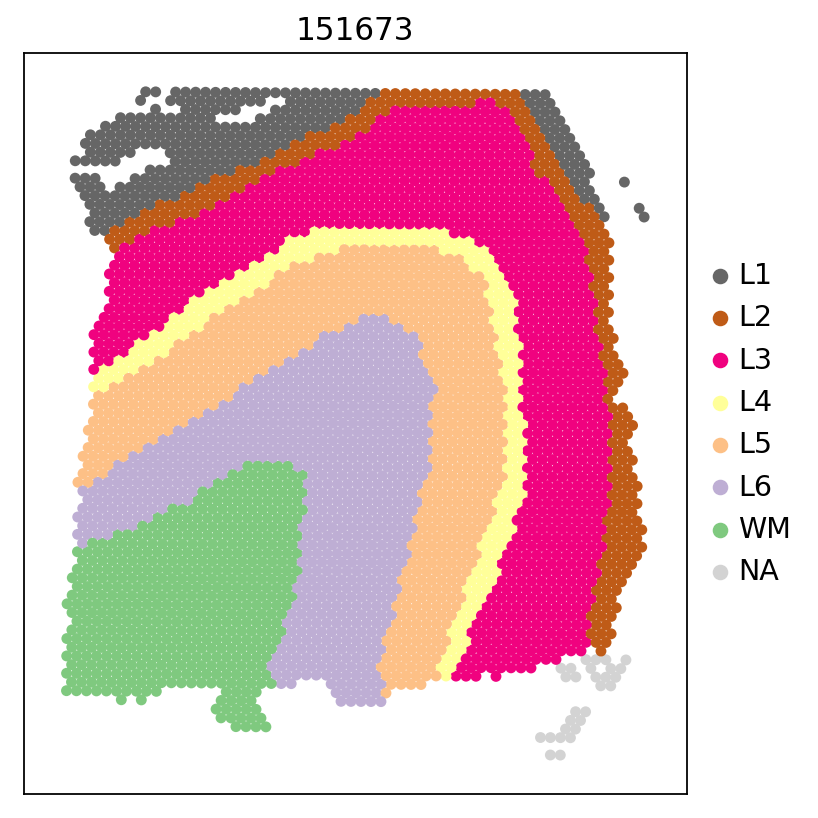

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

sc.pl.spatial(
    adata_spatialLIBD_d[SAMPLE_ID_N],
    img_key=None,
    color="spatialLIBD",
    palette="Accent_r",
    size=1.5,
    title=SAMPLE_ID_N,
    # legend_loc = 4,
    spot_size=100,
    show=False,
    ax=ax,
)

ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")

fig.show()


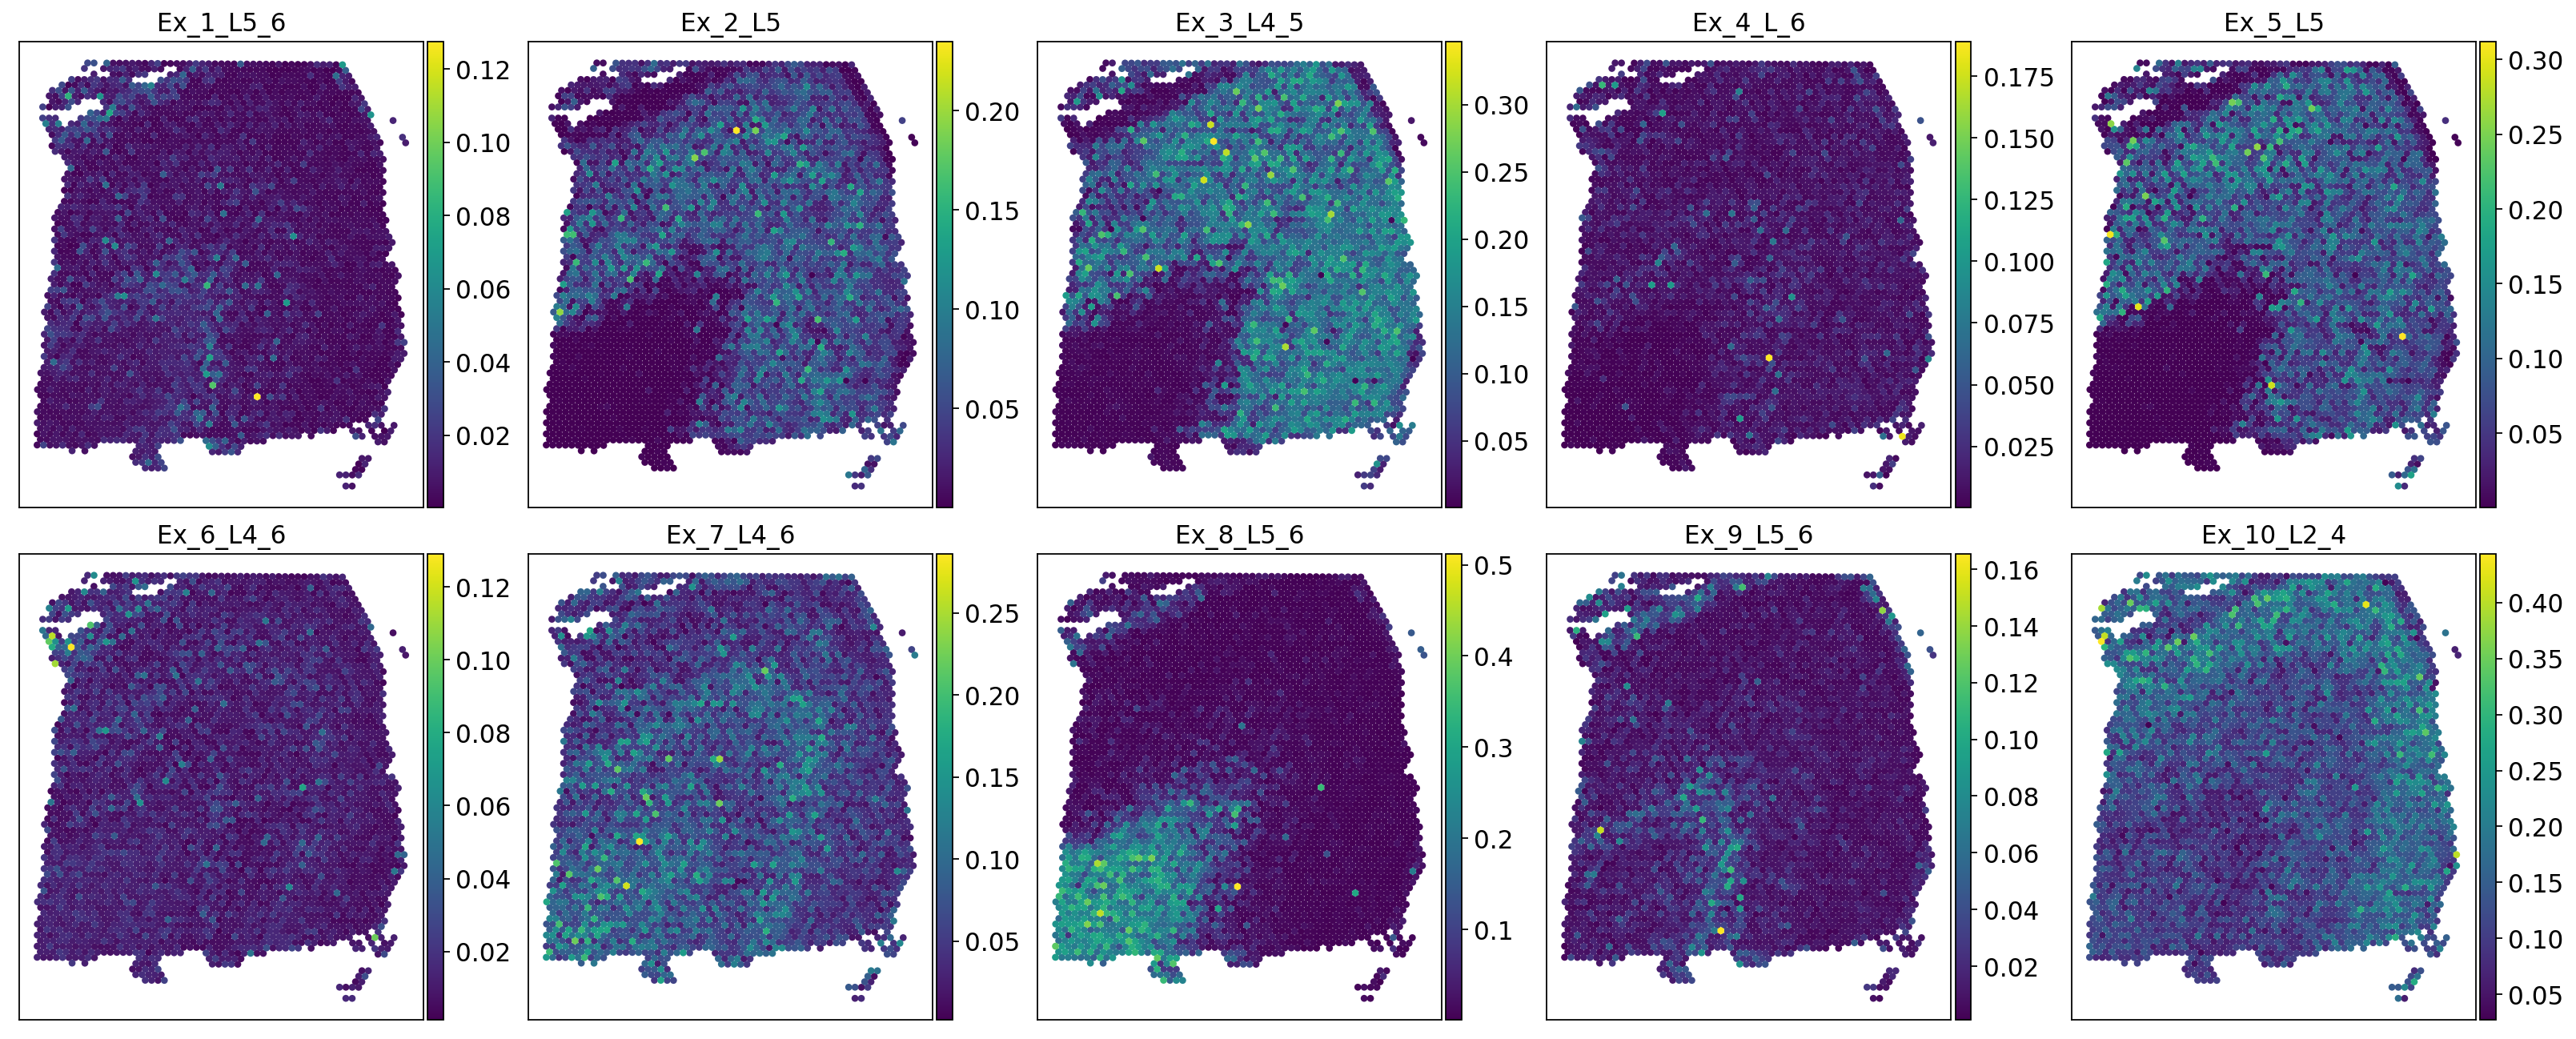

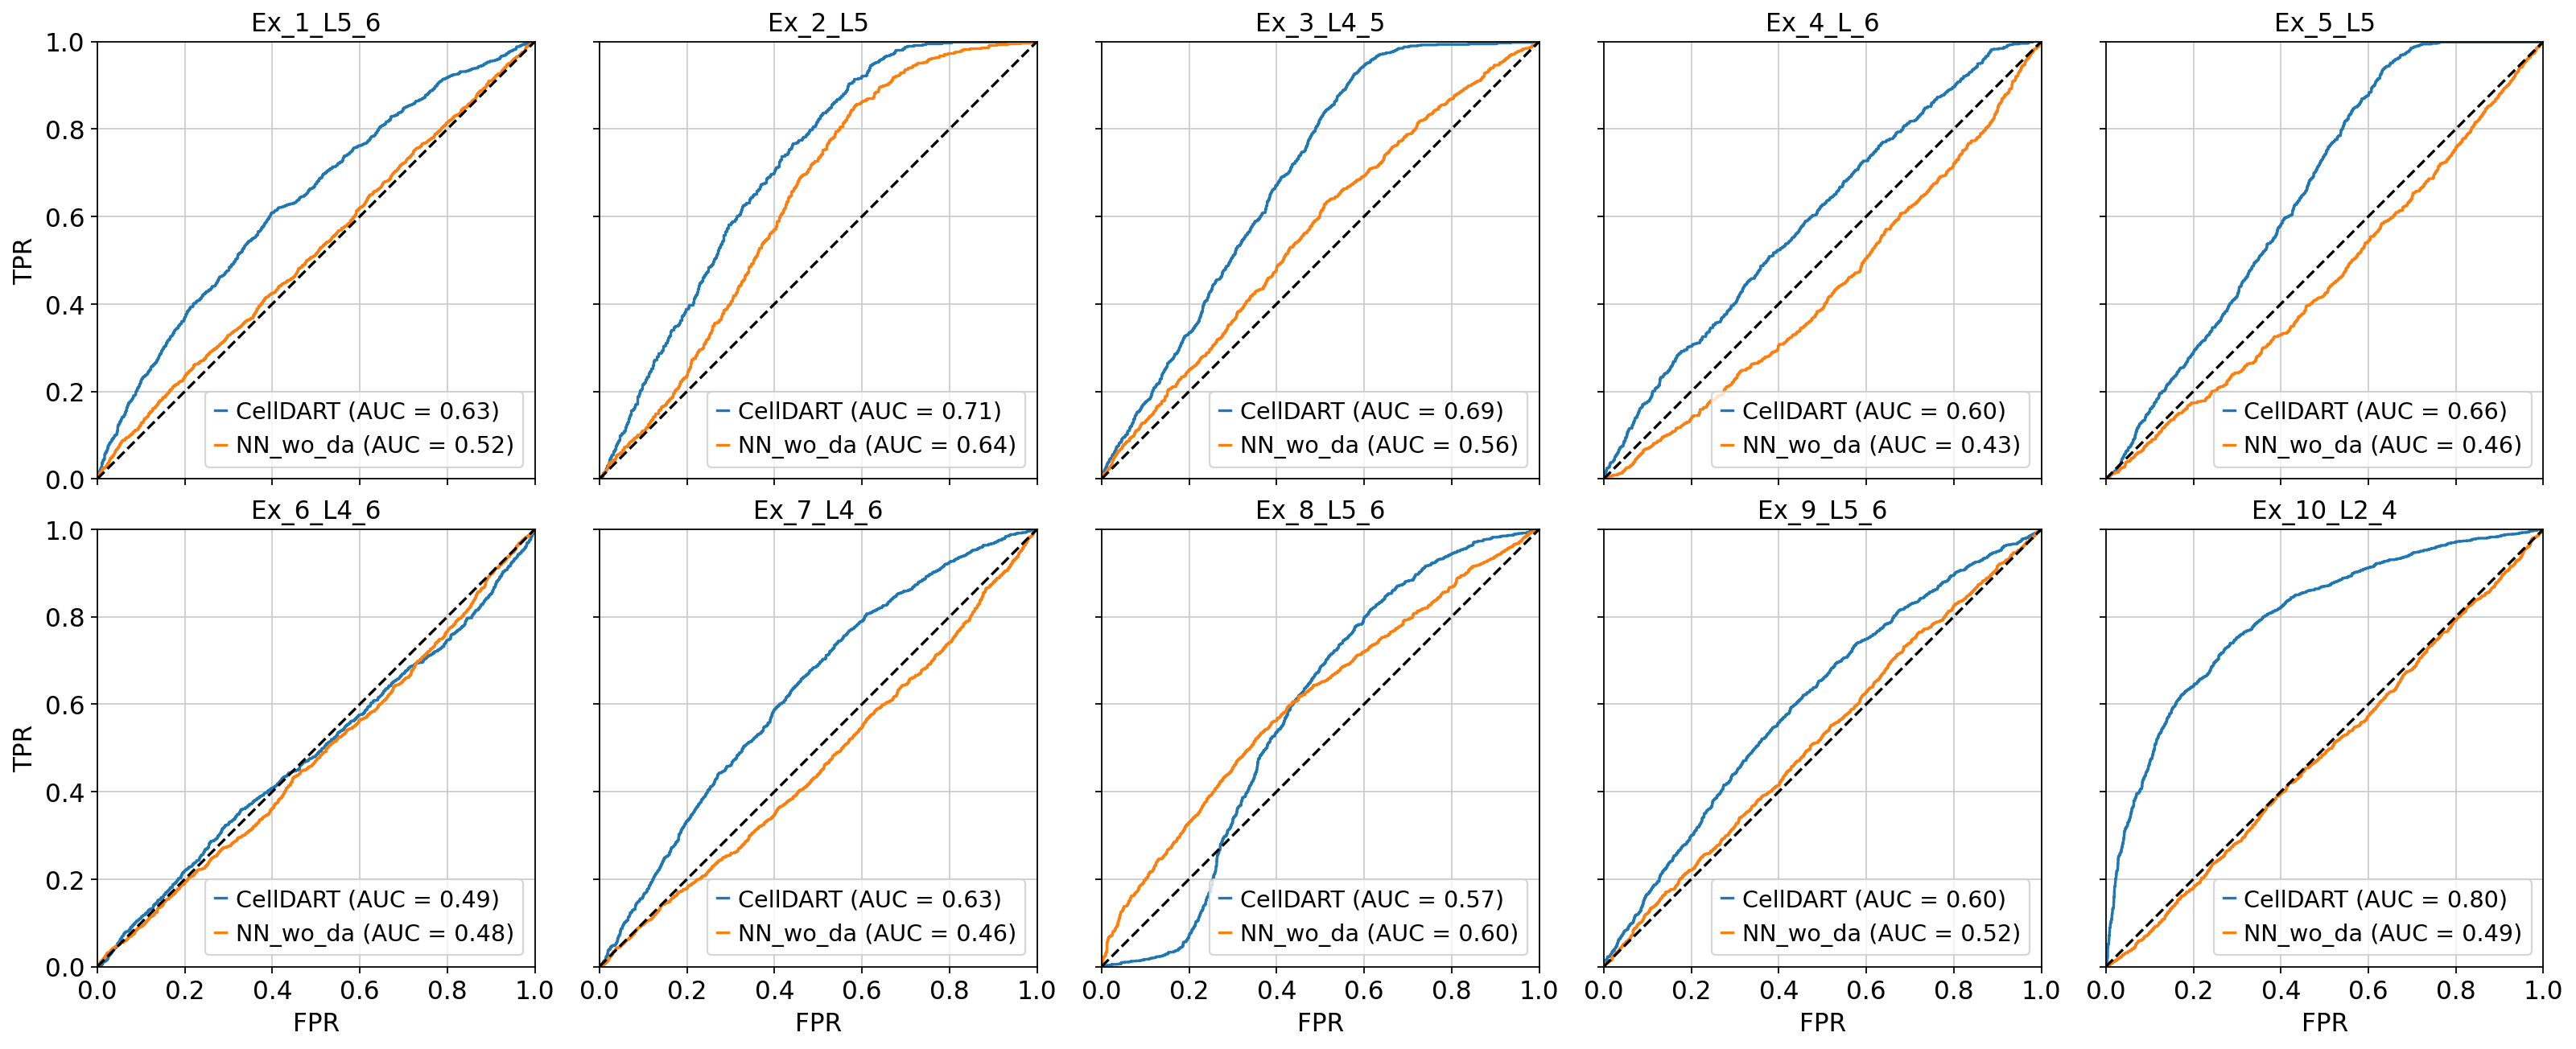

In [42]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

for i, num in enumerate(numlist):
    plot_cellfraction(
        num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
    )
    ax.flat[i].axis("equal")
    ax.flat[i].set_xlabel("")
    ax.flat[i].set_ylabel("")

fig.show()

fig, ax = plt.subplots(
    2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
)

for i, num in enumerate(numlist):
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_d[SAMPLE_ID_N],
        "CellDART",
        ax.flat[i],
    )
    plot_roc(
        num,
        adata_spatialLIBD_d[SAMPLE_ID_N],
        pred_sp_noda_d[SAMPLE_ID_N],
        "NN_wo_da",
        ax.flat[i],
    )
    ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    ax.flat[i].set_title(f"{sc_sub_dict[num]}")

    if i >= len(numlist) - 5:
        ax.flat[i].set_xlabel("FPR")
    else:
        ax.flat[i].set_xlabel("")
    if i % 5 == 0:
        ax.flat[i].set_ylabel("TPR")
    else:
        ax.flat[i].set_ylabel("")

fig.show()


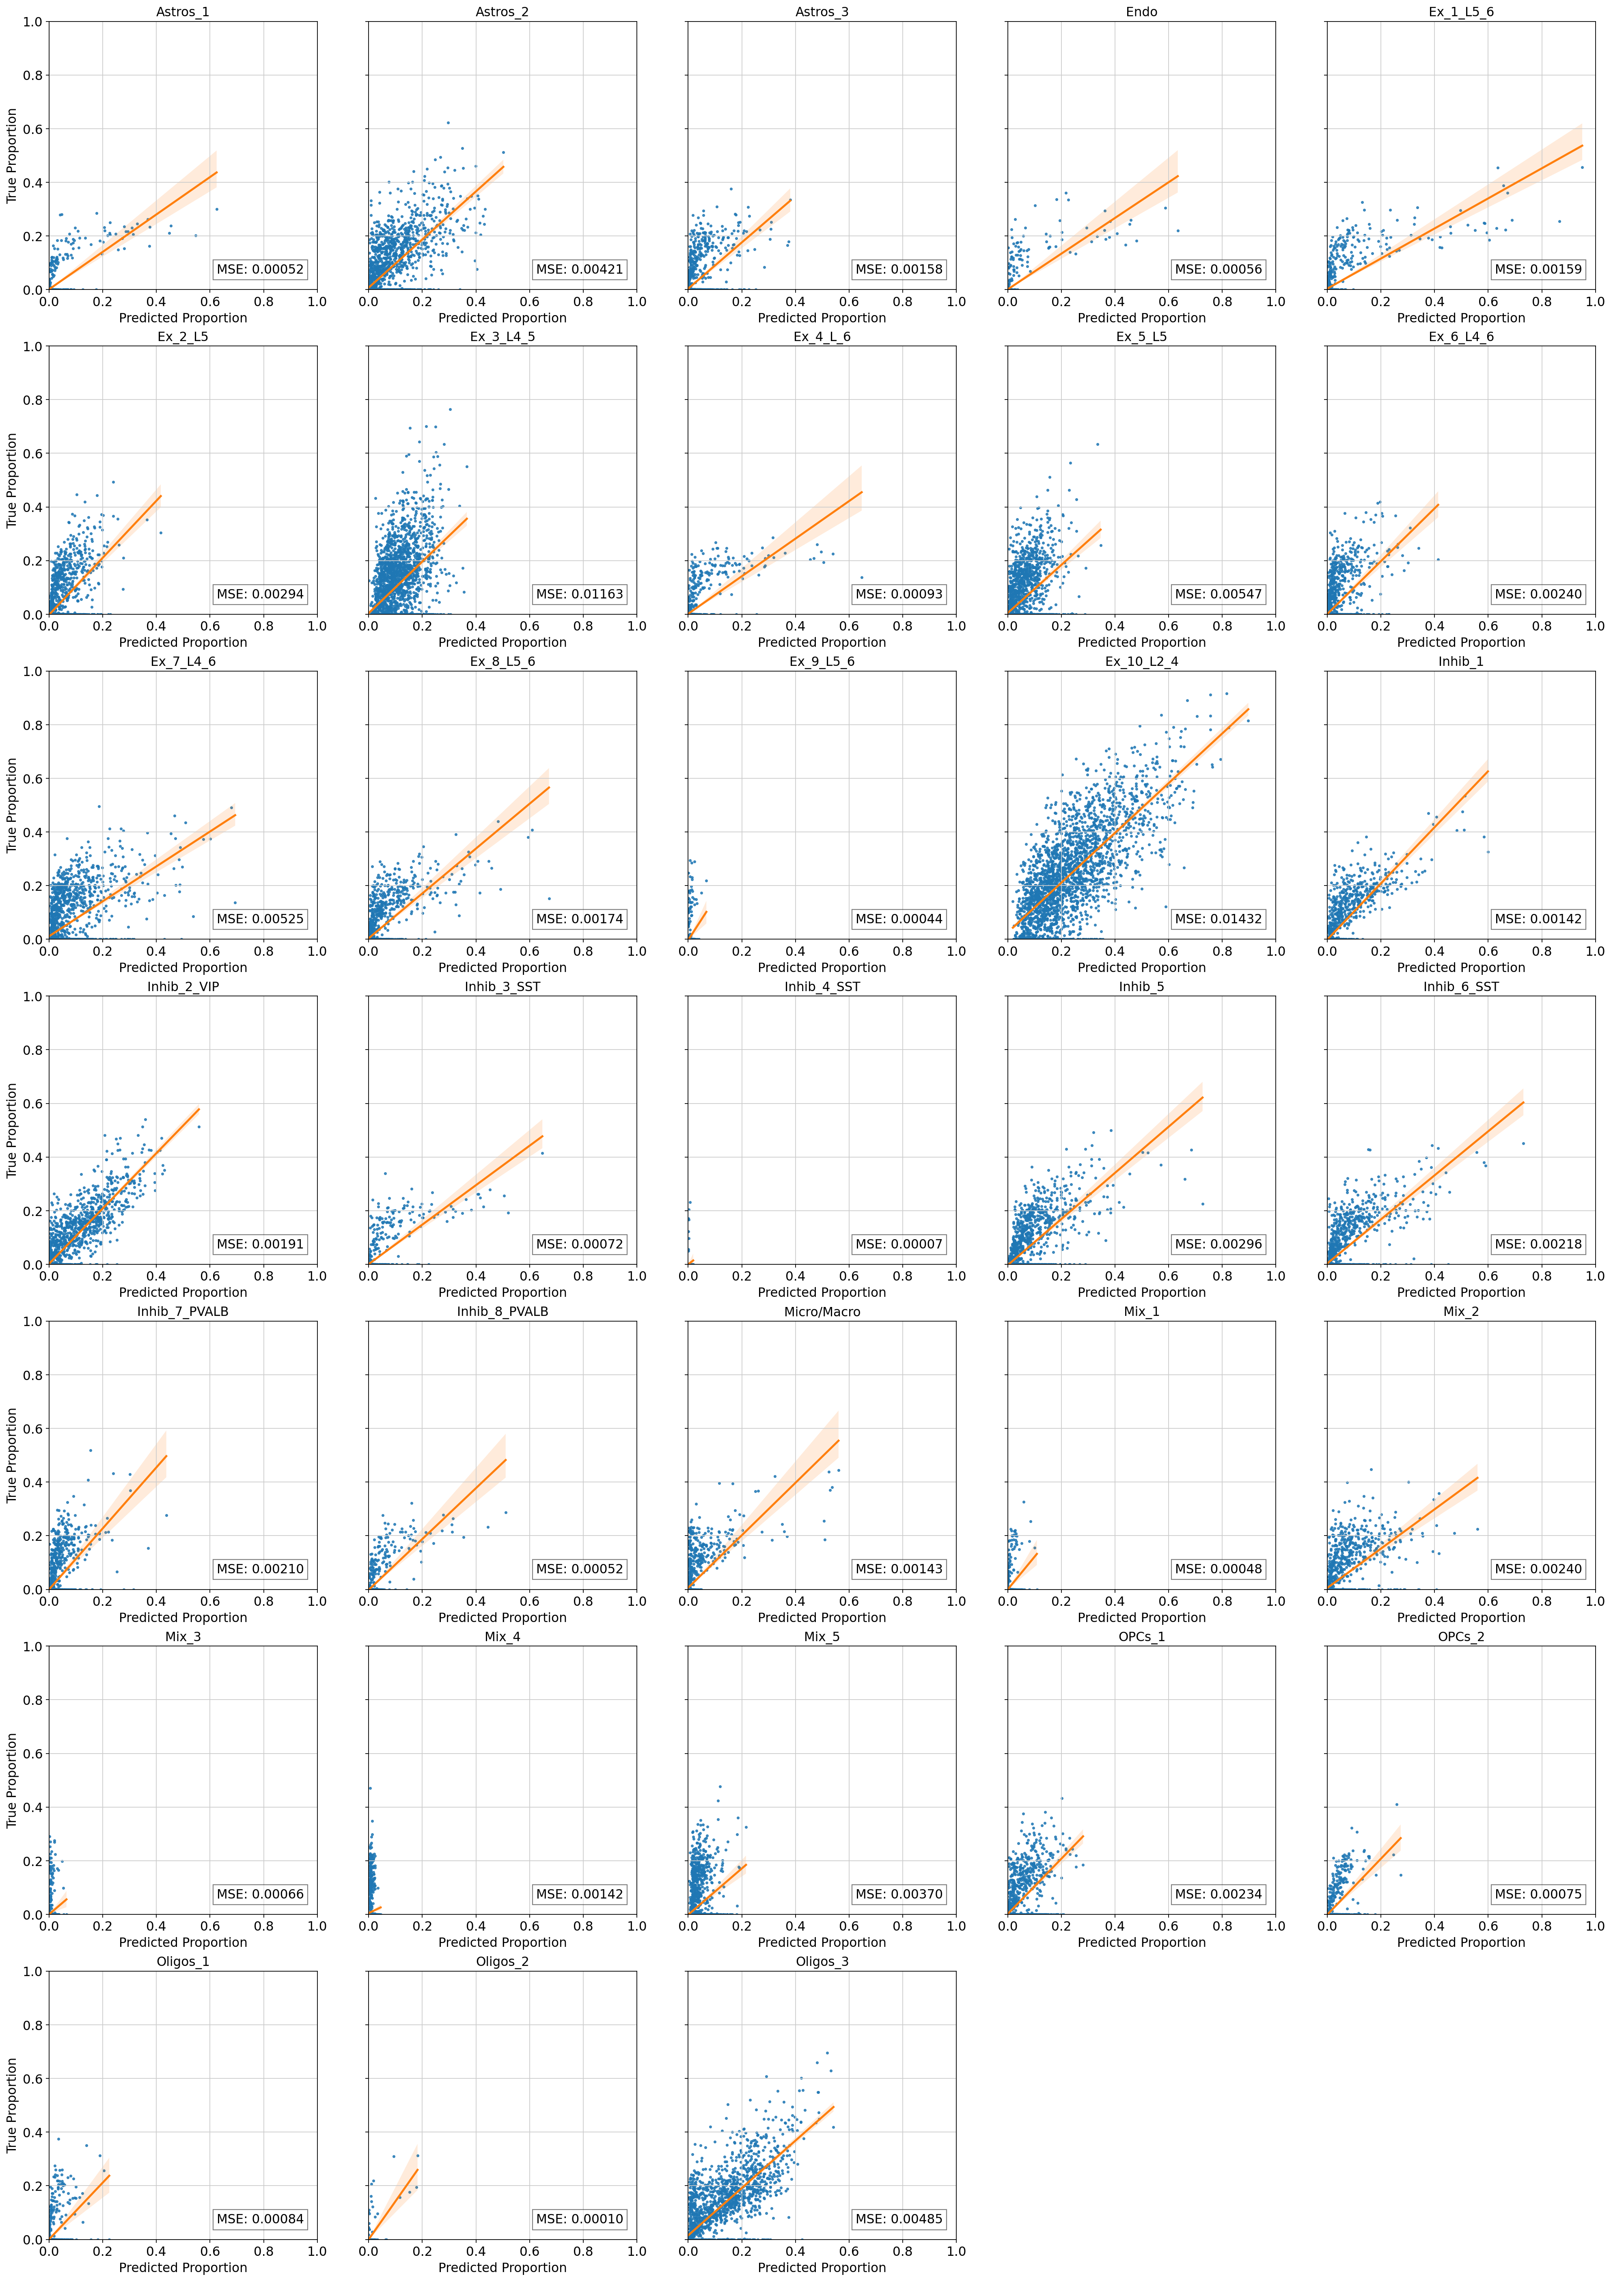

In [43]:
if TRAIN_USING_ALL_ST_SAMPLES:
    best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
else:
    best_checkpoint = torch.load(
        os.path.join(advtrain_folder, SAMPLE_ID_N, f"final_model.pth")
    )

model = best_checkpoint["model"]
model.to(device)

model.eval()
model.set_encoder("source")

pred_mix = (
    F.softmax(model(torch.Tensor(sc_mix_test_s).to(device)), dim=1)
    .detach()
    .cpu()
    .numpy()
)

cell_type_nums = sc_sub_dict.keys()
nrows = ceil(len(cell_type_nums) / 5)

line_kws = {"color": "tab:orange"}
scatter_kws = {"s": 5}

props = dict(facecolor="w", alpha=0.5)

fig, ax = plt.subplots(
    nrows,
    5,
    figsize=(25, 5 * nrows),
    constrained_layout=True,
    sharex=False,
    sharey=True,
)
for i, visnum in enumerate(cell_type_nums):
    sns.regplot(
        x=pred_mix[:, visnum],
        y=lab_mix_test[:, visnum],
        line_kws=line_kws,
        scatter_kws=scatter_kws,
        ax=ax.flat[i],
    ).set_title(sc_sub_dict[visnum])

    ax.flat[i].set_aspect("equal")
    ax.flat[i].set_xlabel("Predicted Proportion")

    if i % 5 == 0:
        ax.flat[i].set_ylabel("True Proportion")
    else:
        ax.flat[i].set_ylabel("")
    ax.flat[i].set_xlim([0, 1])
    ax.flat[i].set_ylim([0, 1])

    textstr = (
        f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
    )

    # place a text box in upper left in axes coords
    ax.flat[i].text(
        0.95,
        0.05,
        textstr,
        transform=ax.flat[i].transAxes,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
    )

for i in range(len(cell_type_nums), nrows * 5):
    ax.flat[i].axis("off")

plt.show()
